# The HFM library - A fast marching solver with adaptive stencils

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Accurate distance from a boundary

The Eikonal equation characterizes the distance from a set, which in applications is typically either:
- a single source point, or a finite set of such points.
- the boundary of a smooth, or piecewise smooth, shape.

Computing the distance map to a high accuracy in the case of source points requires specific techiques, such as the factorization of the source singularity in the PDE, which are embedded within the proposed eikonal solvers and discussed in the [relevant notebook](HighAccuracy.ipynb).
This notebook is devoted to the second case, of accurate geodesic distance computation from a domain boundary, in two dimensions.

**Signed distance from a smooth curve.**
For that purpose, we first estimate the signed distance from a given curve of interest $C\subset \Omega \subset R^2$, with respect to an arbitrary Finsler metric denoted $N_x(v)$, $x \in \Omega$, $v \in R^2$. 
We provide an explicit estimate, which is only valid in a small tubular neighborhood of the curve $C$. This estimate, at a point $x\in \Omega$, is from the mathematical standpoint designed as follows:
- Find a curve point $y\in C$ close to the given point $x\in \Omega$.
- Approximate the curve $C$ with a straight line in the vicinity of $y$. 
- Approximate the geodesic metric $N$ with the constant metric $N_x$ in the vicinity of $x$.

Based on this modeling, the signed distance from $x$ to $C$ can be estimated as:
$$
    d_N(x,C) = \frac{<x-y,n_y>}{ N^*_x(n_y)} + O(\|x-y\|^2),
$$
where $y\in C$ is close to $x$, and $n_y$ is the normal to $C$ at $y$ towards the shape interior - recall that we are computing a signed distance.

Once this estimate is computed, it is used as a seed value for the geodesic distance computation.

**Piecewise smooth curves *without re-entrant corners*.**
The distance from a piecewise smooth shape boundary, *without re-entrant corners*, is estimated as the *minimal distance to each of the smooth boundary pieces*. This approximation is only valid inside the shape, in contrast to the smooth case described above where the obtained signed distance estimate is valid both in the interior and the exterior neighborhood of the shape.

On the other hand, re-entrant corners yield singularities of the distance map which are closely related to those defined by source points. Handling them requires additional care and is outside of the scope of this notebook.

**Extension to non-zero Dirichlet boundary conditions.**
The methods presented in this notebook may be extended to non-zero Dirichlet boundary conditions, provided they are *strictly Lipschitz w.r.t. the metric*. This extension is outside of the scope of this notebook, but let us nevertheless comment that a basic ingredient is solving problems of the following form : find $t\in R$ such that
$$
    N^*(x+t v) = 1
$$
where $N$ is a given norm, and where $x,v$ are given vectors, with $N^*(x)<1$. (In the case of an Isotropic, Riemannian or Randers metric, the above problem amounts to a univariate quadratic equation, which is easily solved.)

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Local approximate geodesic distance to a piecewise smooth boundary](#1.-Local-approximate-geodesic-distance-to-a-piecewise-smooth-boundary)
    * [1.1 Sampling a smooth boundary and its normals](#1.1-Sampling-a-smooth-boundary-and-its-normals)
    * [1.2 Local approximation of the geodesic distance](#1.2-Local-approximation-of-the-geodesic-distance)
    * [1.3 Case of a piecewise smooth boundary](#1.3-Case-of-a-piecewise-smooth-boundary)
  * [2. Validation with constant metrics](#2.-Validation-with-constant-metrics)
    * [2.1 Riemannian case](#2.1-Riemannian-case)
    * [2.2 Randers case](#2.2-Randers-case)
  * [3. An example with a non-constant metric](#3.-An-example-with-a-non-constant-metric)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('DistanceFromBoundary','FMM'))

In [2]:
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
from agd import Eikonal
from agd import Metrics
from agd.AutomaticDifferentiation.Optimization import norm_infinity,norm_average

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.spatial

## 1. Local approximate geodesic distance to a piecewise smooth boundary

We compute a local approximation, in a tubular neighborhood, of the geodesic distance from a piecewise smooth boundary, following the principles given in the introduction and focusing first on the smooth case. The shape boundary is presented as a collection of points and of interior normals to these points.

### 1.1 Sampling a smooth boundary and its normals

It is common, at least in synthetic test cases, that a shape boundary is parametrized analytically, say counter-clockwise. We use automatic differentiation to compute the normals. This step can of course be bypassed if the shape boundary is directly given as a discrete set of points and of interior normals.

**Note : Euclidean normalization of the interior normals.** Our distance estimation formulas are $0$-homogeneous w.r.t. these interior normals, hence their normalization is not required strictly speaking.

In [4]:
# Some curve parametrizing counter-clockwise a shape boundary, 
# presented as a pair (vector function, interval of definition)
smooth_curve = (lambda t : [np.cos(t),np.sin(t)], [0,2*np.pi])

In [5]:
def sample_points_normals(f,Tbounds,Tcount):
    """
    Sample the (smooth closed) parametrized curve defined by 
    the function f over the interval Tbounds, with Tcount points.
    Also returns counter-clocwkise normal vectors at these points.
    """
    T = np.linspace(*Tbounds,Tcount)
    T_ad = ad.Dense.identity(constant=T,shape_free=tuple())
    curve_ad = ad.array( f(T_ad) )
    tangents = curve_ad.coef.squeeze(axis=-1)
    return curve_ad.value, lp.perp(tangents/np.linalg.norm(tangents,axis=0))

In [6]:
# Sample
smooth_points_normals = sample_points_normals(*smooth_curve,50)

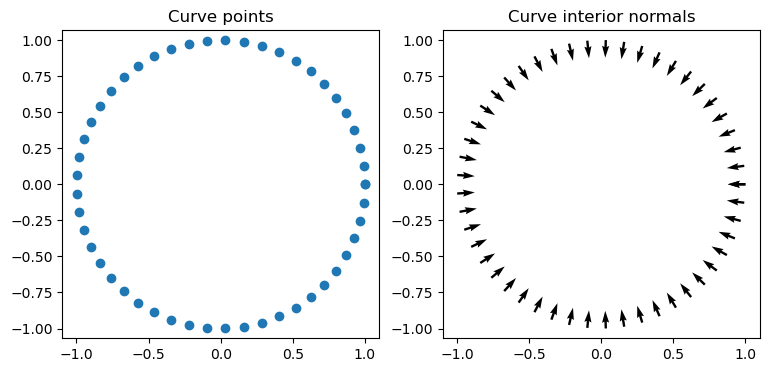

In [7]:
plt.figure(figsize=[9,4])
points,normals = smooth_points_normals

plt.subplot(121); plt.title("Curve points")
plt.scatter(*points); plt.axis("equal")

plt.subplot(122); plt.title("Curve interior normals")
plt.quiver(*points,*normals); plt.axis("equal");

### 1.2 Local approximation of the geodesic distance

Consider a point $x$ of a domain $\Omega$, which is close to a point $y$ of the smooth curve $C \subset \Omega$ of interest. Denote by $n_y$ the interior normal to $C$ at $y$.
Then the signed geodesic distance from $x$ to the curve admits the following Taylor expansion, already mentioned in the introduction
$$
    \frac{<x-y,n_y>} { N^*_x(n_y)} + O(\|x-y\|^2),
$$
where $N^*_x$ is the dual geodesic metric at the point $x$. This approximation only holds:
- close enough to the curve.
- far enough to the curve endpoints.
- assuming bounded curvature.

In [8]:
# The domain
aX = np.linspace(-1,1,101)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

# A constant metric, for now
metric = Metrics.Riemann.from_diagonal([1,2**2]).rotate_by(0.3)

In [9]:
def smooth_local_distance(Y,N,X,metric):
    """
    Locally approximates the signed geodesic distance to a smooth curve.
    Y : points of the curve
    N : normals to the curve
    X : points of the domain
    metric : geodesic metric
    width : width of the tubular neighborhood
    """
    
    # Construct a KDTree to query the closest curve point
    curve_tree = scipy.spatial.KDTree(Y.T)
    eucl_dist,best = curve_tree.query(np.moveaxis(X,0,-1))
    
    geo_dist = lp.dot_VV(X-Y[:,best],N[:,best]) / metric.dual().norm(N[:,best])
    return geo_dist,eucl_dist

In [10]:
geo_dist,eucl_dist = smooth_local_distance(*smooth_points_normals, X, metric)

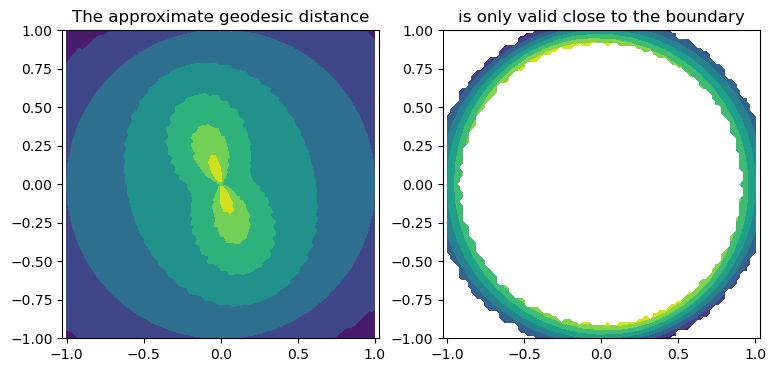

In [11]:
plt.figure(figsize=[9,4])

plt.subplot(121); plt.title("The approximate geodesic distance")
plt.contourf(*X,geo_dist); plt.axis('equal');

plt.subplot(122)
plt.title("is only valid close to the boundary")
plt.contourf(*X,np.where(eucl_dist<=0.1,geo_dist,np.inf)); plt.axis('equal');

### 1.3 Case of a piecewise smooth boundary

We first define a piecewise smooth closed curve, parametrized counter-clockwise. As discussed in the introduction, we assume *no re-entrant corners*.

In [12]:
piecewise_curve = [
    (lambda t:[t,-np.ones_like(t)],        [-1,1]),
    (lambda t:[np.ones_like(t),t],         [-1,0]),
    (lambda t:[np.cos(t),np.sin(t)],       [0,np.pi/2]),
    (lambda t:[-t,np.ones_like(t)],        [0,1]),
    (lambda t:[-np.ones_like(t),-t],       [-1,1]),
]

In [13]:
piecewise_points_normals = [sample_points_normals(f,Tbounds,20) for f,Tbounds in piecewise_curve]

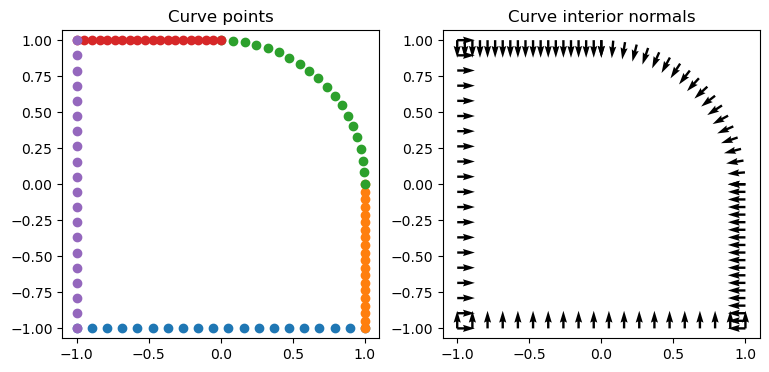

In [14]:
plt.figure(figsize=[9,4])

plt.subplot(121); plt.title("Curve points")
for points,_ in piecewise_points_normals: 
    plt.scatter(*points); plt.axis("equal")

plt.subplot(122); plt.title("Curve interior normals")
for points,normals in piecewise_points_normals: 
    plt.quiver(*points,*normals)
plt.axis("equal");

In [15]:
def piecewise_local_distance(YN,X,metric):
    dists = [smooth_local_distance(Y,N,X,metric) for Y,N in YN]
    return np.min([geo for geo,_ in dists],axis=0),np.min([eucl for _,eucl in dists],axis=0)

In [16]:
geo_dist,eucl_dist = piecewise_local_distance(piecewise_points_normals,X,metric)

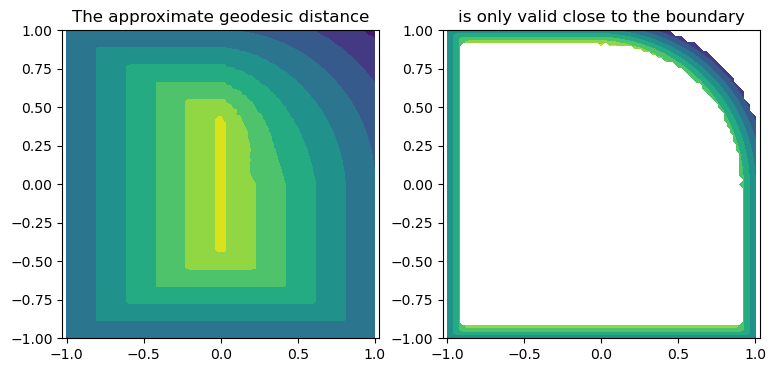

In [17]:
plt.figure(figsize=[9,4])

plt.subplot(121); plt.title("The approximate geodesic distance")
plt.contourf(*X,geo_dist); plt.axis('equal');

plt.subplot(122)
plt.title("is only valid close to the boundary")
plt.contourf(*X,np.where(eucl_dist<=0.1,geo_dist,np.inf)); plt.axis('equal');

## 2. Validation with constant metrics

When the metric is constant over the domain, the distance from its boundary can be computed using a variety of alternative techniques to eikonal equation solvers. Note that minimal paths to the domain boundary are straight lines in this context. These alternative computations are used to validate the FMM solver.

### 2.1 Riemannian case

We compute the distance to the piecewise smooth boundary using a constant Riemannian metric.

<!---
Note that the distance computed is only valid inside the circle.

In this specific case, it would not be too hard to compute an exact solution.
--->

In [18]:
metric = Metrics.Riemann.from_diagonal([1,2**2]).rotate_by(0.3)

In [19]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'metric':metric,
    'exportValues':True,
})
hfmIn.SetRect(sides = [[-1,1],[-1,1]],dimx=101)
X = hfmIn.Grid()

In [20]:
piecewise_points_normals = [sample_points_normals(f,Tbounds,50) for f,Tbounds in piecewise_curve]
geo_dist,eucl_dist = piecewise_local_distance(piecewise_points_normals,X,metric)

In [21]:
tube = eucl_dist<0.1
hfmIn['seeds'] = X[:,tube].T
hfmIn['seedValues'] = geo_dist[tube]

In [22]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.002111 s.


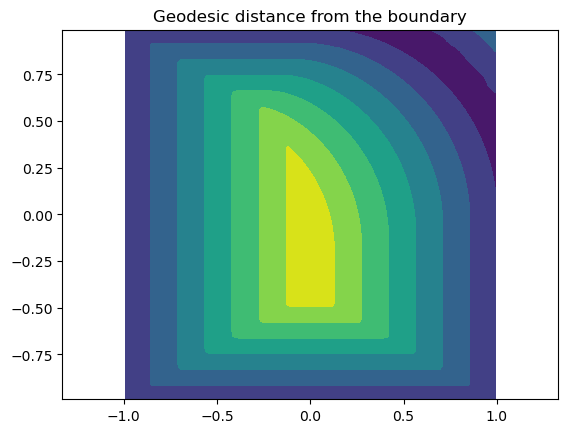

In [23]:
plt.title("Geodesic distance from the boundary")
plt.contourf(*X,hfmOut['values'])
plt.axis('equal');

A constant Riemannian metric is, up to a linear change of variable, identical to the Euclidean metric. We take advantage of this to compute the distance to the boundary using a KDTree structure.

In [24]:
A = scipy.linalg.sqrtm(metric.m)
points = np.concatenate([sample_points_normals(f,Tbounds,200)[0] for f,Tbounds in piecewise_curve],axis=1)
tree = scipy.spatial.KDTree(lp.dot_AV(A[:,:,None],points).T)
tree_dist,_ = tree.query(np.moveaxis(lp.dot_AV(A[:,:,None,None],X),0,-1))

In [25]:
# Difference between the KDTree based computation, 
# and the accurate eikonal computation
domain = (X[0]<=0) | (X[1]<=0) | (X[0]**2+X[1]**2<=1)
diff_accurate = domain*(hfmOut['values']-tree_dist)

On the other hand, we can approximate the distance to the domain boundary using the eikonal solver in a less sophisticated manner, simply by setting null boundary conditions on the square complement.

In [26]:
square = np.max(np.abs(X)+hfmIn.gridScales[:,None,None],axis=0)>=1 
hfmIn['seeds'] = X[:,square|~domain].T
hfmIn.pop('seedValues',None);

In [27]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.002276 s.


In [28]:
# Difference between the KDTree based computation, 
# and the basic eikonal computation
diff_raw = domain*(hfmOut['values']-tree_dist)

The improvement due to accurate boundary conditions is particularly clear in the averaged $L^1$ norm over the domain.

In [29]:
error_accurate,error_raw = norm_average(diff_accurate),norm_average(diff_raw)
print(f"Mean error using the accurate ({error_accurate}), "+
      f"and raw ({error_raw}), discretization of the boundary conditions. "+
      f"Improvement ratio : {error_raw/error_accurate}.")

Mean error using the accurate (0.0003665311153636545), and raw (0.010816582623881842), discretization of the boundary conditions. Improvement ratio : 29.5106804592842.


In [30]:
assert norm_average(diff_accurate)<1e-3
assert norm_average(diff_raw)<2e-2

The improvement is less clear in the maximum norm, which could be expected. Indeed, the distance to the boundary is non-smooth, and has a singularity along a skeleton known as the cut-locus of the shape. The eikonal solver is bound to make a significant error along the cut locus, independently of the quality of the boundary data.

In [31]:
error_accurate,error_raw = norm_infinity(diff_accurate),norm_infinity(diff_raw)
print(f"Maximum error using the accurate ({error_accurate}), "+
      f"and raw ({error_raw}), discretization of the boundary conditions. "+
      f"Improvement ratio : {error_raw/error_accurate}.")

Maximum error using the accurate (0.009334433532029063), and raw (0.023483510813234687), discretization of the boundary conditions. Improvement ratio : 2.5157938864373683.


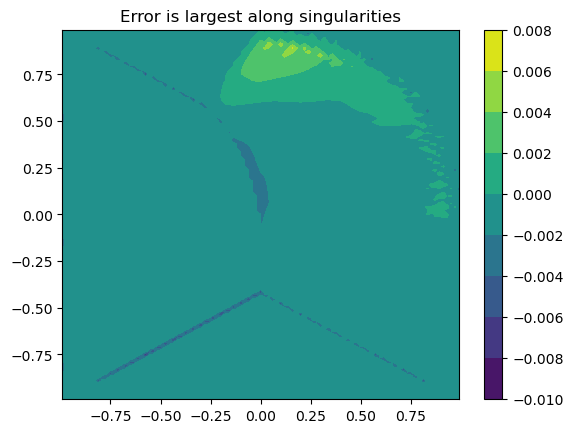

In [32]:
plt.title("Error is largest along singularities")
plt.contourf(*X,diff_accurate); plt.colorbar();

### 2.2 Randers case

We compute the distance to a circular boundary using a well chosen Randers metric,  for which this distance has an explicit closed form. We perform this computation so as to validate the signs and orientations involved in our distance estimate. Indeed, Randers metrics are asymmetric generalizations of Riemannian metrics, as a result they define asymmetric path length distances, which puts such sign issues into light. See this [notebook on Randers metrics](Rander.ipynb) for context.

Following Zermelo's navigation problem, we consider a vehicle moving at unit Euclidean speed, but subject to a given drift. By construction, at time $1$, the vehicle reaches the unit circle offset by the drift.
Reversing time, we obtain an explicit solution to an eikonal equation with a Randers metric, with a null boundary condition on the circle.

In [33]:
drift = np.array([0.5,0.3])

# Randers metric corresponding to Zermelo's navigation problem,
# with a unit speed and the given drift
metric = Metrics.Rander.from_Zermelo(np.eye(2),drift)

# Time reversed metric
metric_rev = metric.with_speed(-1)

In [34]:
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'metric':metric,
    'exportValues':True,
})
hfmIn.SetRect(sides = [[-1,1],[-1,1]],dimx=101)
X = hfmIn.Grid()

As announced, we have an exact formula for the distance to the unit circle with this metric.

In [35]:
exact_dist = 1-metric_rev.norm(X-drift[:,None,None])

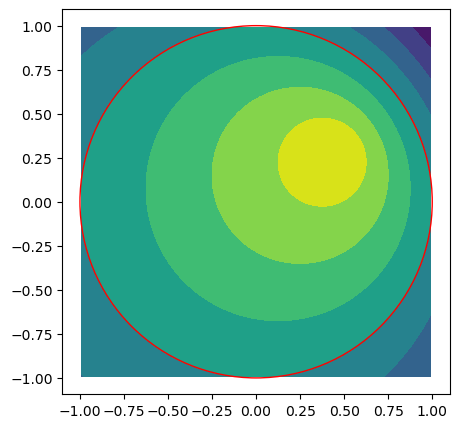

In [36]:
ax = plt.figure(figsize=[5,5]).gca()
plt.contourf(*X,exact_dist)
ax.add_patch(plt.Circle((0, 0), 1, color='r',fill=False))
plt.axis('equal');

We use the developed techniques to compute a local approximation of the geodesic distance, close to the circle.

In [37]:
smooth_points_normals = sample_points_normals(*smooth_curve,200)
geo_dist,eucl_dist = smooth_local_distance(*smooth_points_normals, X, metric)

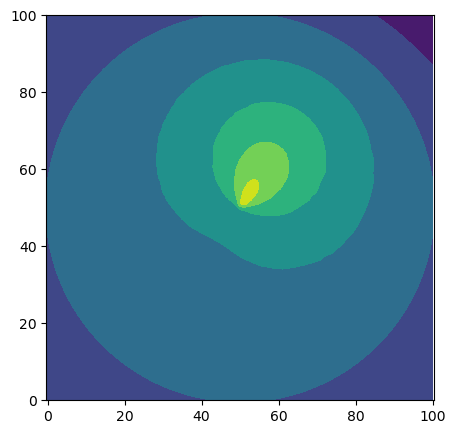

In [38]:
plt.figure(figsize=[5,5])
plt.contourf(geo_dist) 
plt.axis('equal');

Keeping only this data in a tubular neighborhood of the boundary, and using a Randers eikonal solver elsewhere, we reconstruct the solution.

In [39]:
tube = eucl_dist<0.1
hfmIn['seeds'] = X[:,tube].T
hfmIn['seedValues'] = geo_dist[tube]

In [40]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.005198 s.


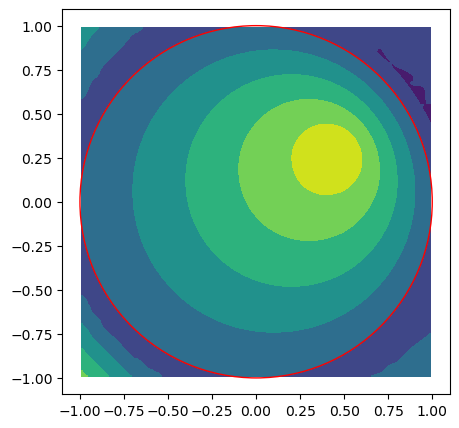

In [41]:
ax = plt.figure(figsize=[5,5]).gca()
plt.contourf(*X,hfmOut['values'])
ax.add_patch(plt.Circle((0, 0), 1, color='r',fill=False))
plt.axis('equal');

In [42]:
domain = np.linalg.norm(X,axis=0)<=1
diff_accurate = (hfmOut['values']-exact_dist)*domain

A more basic approach to compute the geodesic distance is to set null boundary conditions at all points of the domain complement. But this is considerably less accurate.

In [43]:
hfmIn['seeds'] = X[:,~domain].T
hfmIn.pop('seedValues',None); # Key defaults to zeros

In [44]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.005292 s.


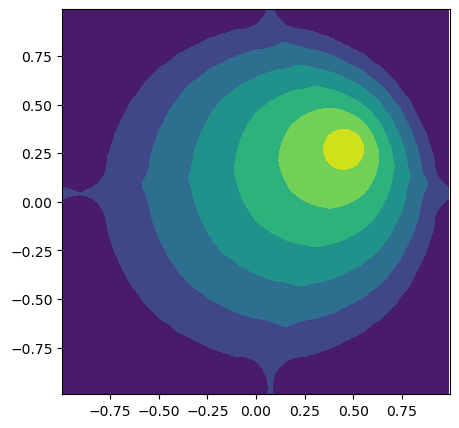

In [45]:
plt.figure(figsize=[5,5])
plt.contourf(*X,hfmOut['values'])
plt.axis('equal');

In [46]:
diff_raw = (hfmOut['values']-exact_dist)*domain

The improvement brought by the accurate implementation of the boundary conditions is clear.

In [47]:
error_accurate,error_raw = norm_average(diff_accurate),norm_average(diff_raw)
print(f"Mean error using the accurate ({error_accurate}), "+
      f"and raw ({error_raw}), discretization of the boundary conditions. "+
      f"Improvement ratio : {error_raw/error_accurate}.")

Mean error using the accurate (0.0006465837447139519), and raw (0.006665195356973108), discretization of the boundary conditions. Improvement ratio : 10.308324964033522.


In [48]:
assert norm_average(diff_accurate)<1e-3
assert norm_average(diff_raw)<1e-2

In this test case, the accurate discretization of the boundary condition also yields a substantial improvement in the maximum norm. This phenomenon is welcome, but it is not generic and is mostly due to a favorable test case configuration. Indeed, the scheme accuracy in the max norm is because the solution only has a single singularity, as opposed to a one dimensional cut-locus in the generic case.

In [49]:
error_accurate,error_raw = norm_infinity(diff_accurate),norm_infinity(diff_raw)
print(f"Maximum error using the accurate ({error_accurate}), "+
      f"and raw ({error_raw}), discretization of the boundary conditions. "+
      f"Improvement ratio : {error_raw/error_accurate}.")

Maximum error using the accurate (0.006124679861986476), and raw (0.16943984741589285), discretization of the boundary conditions. Improvement ratio : 27.665094541110726.


## 3. An example with a non-constant metric

We consider Zermelo's navigation problem, with a varying drift over the domain, the [notebook on Randers metrics](Rander.ipynb) for more context. The methods presented in the constant metric can be used without modification.

In [50]:
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'exportValues':True,
})
hfmIn.SetRect(sides = [[-1,1],[-1,1]],dimx=101)
X = hfmIn.Grid()

In [51]:
R = np.linalg.norm(X,axis=0)
ρ=0.7
driftMult = ρ*np.sin(2*np.pi*X[0])*np.sin(2.*np.pi*X[1])
drift = (driftMult/R) * X

In [52]:
metric = Metrics.Rander.from_Zermelo(np.eye(2),drift)
hfmIn['metric']=metric

In [53]:
piecewise_points_normals = [sample_points_normals(f,Tbounds,50) for f,Tbounds in piecewise_curve]
geo_dist,eucl_dist = piecewise_local_distance(piecewise_points_normals,X,metric)

In [54]:
tube = eucl_dist<0.1
hfmIn['seeds'] = X[:,tube].T
hfmIn['seedValues'] = geo_dist[tube]

In [55]:
hfmIn.SetUniformTips([6,6]) # Add a few tips from which to backtrack geodesics

In [56]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.004877 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


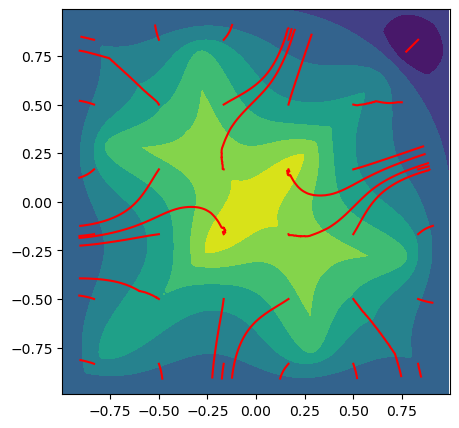

In [57]:
ax = plt.figure(figsize=[5,5]).gca()
plt.contourf(*X,hfmOut['values'])
for geo in hfmOut['geodesics']: plt.plot(*geo,color='r')
plt.axis('equal');